## Attempts to Disproving the Efficient Market Hypothesis
### Name: Rudraksh Garg

## Introduction

The stock market has been studied by many as people hope to find ways to make excess profits. People attempt to read company reports or mathematical equations or even view satellite images to evaluate and trade stocks. In this case we will be using machine learning to complete the same tasks.

The basis of all of these prediction attempts comes from the idea of the Efficient Market Hypothesis (EMH). EMH states that a stock's price incorporates all of the information (historic, public, private) available in the market. There are 3 markets forms in EMH: weak-form, semi-strong form, and strong form. The weak form market explains that the market price of a stock incorporates only historical information. This means that investors are only able to obtain excessive gains if that have access to public and private information.

In this project, we plan to disprove the weak-form efficient market as we want to use historical prices and technical analysis as inputs into a neural network in order to predict the perfect buy-in and sell-out times and get excessive gains than the standard buy-and-hold method. There are 3 approaches explained below: multi-class classification, binary classification, and regression.

## Importing Libraries

### Import Data Analytics Libraries
- **Pandas**: Used for data analysis and data preparation
- **Numpy**: Arrays and other mathematical expressions 
- **Matplotlib**: Plotting data points
- **Datetime**: Manipulate dates
- **Scikit-learn (Sklearn)**: Machine learning library for Python
    - *preprocessing.MinMaxScaler*: Used for normalizing data


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler


Bad key text.latex.preview in file C:\Users\rudra\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\rudra\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\rudra\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

### Import Project Specific Libraries
- **Yahoo Finance (yfinance)**: Gather ticker data
- **Backtrader Technical Analysis Library (bta-lib)**: Gather trends and pattern indicators

In [2]:
import btalib
import yfinance as yf

### Import Web Scraping Libraries
- **requests**: Gather web data
- **urllib**: Gather web data
- **BeautifulSoup**: Extract web data

In [3]:
import requests
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

### Import Deep Learning Libraries
- **PyTorch**: Create neutral networks
- **TensorBoard**: Visualize training statistics


In [4]:
import torch
import torch.utils.tensorboard as tb


### Import Natural Language Processing Tools
- **transformers**: Use pre-trained deep learning models

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

### Import API Keys
- **config**: Holds all private API keys


In [6]:
from config import *

## Data Collection

We will be using Yahoo Finance in order to find the ticker data. This data will include:

- **Date/DateTime**: Index
- **Open**: Price of asset at beginning of Date/Datetime
- **High**: Highest price of asset during Date/Datetime
- **Low**: Lowest price of asset during Date/Datetime
- **Close**: Price of stock at end of Date/Datetime
- **Adj Close**: Close price adjusted due to corporate actions such as dividend payouts, stock splits, or the issuance of more shares

In [7]:
def get_data(symbol, interval = "1d", start_date = "2012-01-01", end_date = "2021-12-31"):
   
    '''
    Returns asset information

            Parameters:
                    symbol (string): ticker symbol for lookup
                    interval (string): periods between datapoints (valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo)
                    start_date (string): format YYYY-MM-DD
                    end_date (string): format YYYY-MM-DD
            Returns:
                    (DateFrame): Asset Information  
    '''

    return yf.download(symbol, start=start_date, end=end_date, interval=interval)

In [8]:
# Pull Apple Stock data
data = get_data("AAPL")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.557465,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.624949,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.765115,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.898558,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.878099,394024400


# Feature Construction

## Technical Analysis

A part of this study is to try and see if a model can use technical analysis (TA) as a way to create a trading strategy.

Technical analysis is the study of trends and patterns in order to predict profitable trading decisions. There are 4 types of indictors we will in this study:

- trend indictors
- momentum indicators
- volatility indicators
- volume indicators. 

Typically, traders use only a 2-3 indictors for their strategy, however, our job is to also see if a model can determine which indictors are more important when making these decisions as well.

In order to add TA to our data, we will be using bta-lib.

Below, we will go in depth into a few indictors and how they are used.

### Simple Moving Average

The simple moving average indictor is a trend indictor that finds the average price within a certain window of time. This helps smooth out the noise in price changes and helps traders see the general trend of the asset's price.

Many traders also use two different moving averages on the same asset. One moving average would have a longer period than the other. In order to buy, the shorter moving average would have to be greater than the longer moving average, indicating that there is a rapid change in price upwards. The same is true vice versa.

We will test if the model could potentially recognize this pattern and gauge if it is useful.



![SMA](images/SMA.PNG)

This chart shows Apple stock prices using the moving average indictors. The purple line shows the short term moving average of 12 days and the yellow line shows the long term moving average of 26 days. The green "up" arrow shows where a trader would buy and the red "down" arrow shows where a trader would sell using this strategy.

In [9]:
def get_MA(data, short_period=12, long_period=26):

    '''
    Adds Moving Averages to asset data

        Parameters:
                data (DataFrame): asset data
                short_period (int): period over moving average taken (<long_period)
                long_period (int): period over moving average taken (>short_period)

        Returns:
                (DateFrame): Asset Information
    '''

    # Get Moving Averages
    ShortMA = btalib.sma(data, period=short_period)
    LongMA = btalib.sma(data, period=long_period)

    # Add to current data
    data["ShortMA"] = ShortMA.df
    data["LongMA"] = LongMA.df

    return data

### Exponential Moving Average

The exponential moving average is similar to the simple moving average, however, it gives higher weigh to more recent changes within the window of time. This could better help find short term price trends than the simple moving average.

Note: may only use this rather than the simple moving average for the model.

![EMA](images/EMA.PNG)

This chart shows Apple stock prices using the exponential moving average indictors. The purple line shows the short term moving average of 12 days and the yellow line shows the long term moving average of 26 days. The green "up" arrow shows where a trader would buy and the red "down" arrow shows where a trader would sell using this strategy.

In [10]:
def get_EMA(data, short_period=12, long_period=26):
    '''
    Adds Exponential Moving Averages to asset data

        Parameters:
                data (DataFrame): asset data
                short_period (int): period over moving average taken (<long_period)
                long_period (int): period over moving average taken (>short_period)

        Returns:
                (DateFrame): Asset Information 
    '''
    # Get Exponential Moving Averages
    ShortEMA = btalib.ema(data, period=12)
    LongEMA = btalib.ema(data, period=26)
    
    # Add to data
    data["ShortEMA"] = ShortEMA.df
    data["LongEMA"] = LongEMA.df

    return data

### Bollinger Bands


The Bollinger Bands indictors is a kind of volatility indictor which uses the moving average over a portion of days and finds a certain standard deviation above and below that moving average. This indictor relies on the theory of mean reversion where asset prices, after spikes in price changes, revert towards the moving average of price. This indictor also shows how volatile an asset is; if the bands are farther apart, then the more volatile the asset is. Traders may use this strategy by buying an asset when the price reaches the lower standard deviation and then sell at the higher standard deviation. Usually, traders use 2 standard deviations away from the mean and have a moving average window of 20 periods.

![Simple Bollinger Bands](images/simpleBBands.PNG)

The purple lines are two standard deviations and the yellow line is the moving average.

Of course, this strategy by itself or unaltered is not perfect, as it may miss out on trends. However, with stop losses (selling if price drops below certain value), band line slopes, and pattern recognition, this strategy may help the model learn more about correct buy and sell signals.

Another possible way to improve this strategy is to add another set of Bollinger Bands that have a different standard deviation.

![Double Bollienger Bands](images/doubleBBands.PNG)

Now the added blue lines are one standard deviation away from moving average and in this case, a strategy could be that a trader could buy at the lower wider (2 std) line and sell when the price touches the upper wider line and then falls below the upper narrow line (1 std)

More research is needed to be done in this case but this might help model learn.

In [11]:
def get_BBands(data, period=20, wider_std=2, narrow_std=1):
    
    '''
    Adds Bollinger Bands to asset data

        Parameters:
                data (DataFrame): asset data
                period (int): period over moving average taken
                wider_std (float): standard deviation of wider bands (>narrow_std)
                narrow_std (float): standard deviation of narrow bands (<wider_std)


        Returns:
                (DateFrame): Asset Information 
    '''

    try:
        # Get Bollinger Bands (regular and narrowed)
        mid, top, bot = btalib.bbands(data, period = period, devs = wider_std)
        mid_narrow, top_narrow, bot_narrow = btalib.bbands(data, period = period, devs = narrow_std)
    except ValueError:
        print("Data broken...check timeframe")
        return None

    # Add to asset data
    data["Mid BBand"] = list(mid)
    data["Top BBand"] = list(top)
    data["Bot BBand"] = list(bot)
    data["Volatility"] = data["Top BBand"] - data["Bot BBand"]
    
    data["Mid BBand Narrow"] = list(mid_narrow)
    data["Top BBand Narrow"] = list(top_narrow)
    data["Bot BBand Narrow"] = list(bot_narrow)
    
    return data

### Relative Strength Index

The Relative Strength Index (RSI) is a momentum indictor that shows how oversold or overbought an asset is. Typically traders would sell when RSI is above 70 as the asset would be considered overbought and overvalued and buy when RSI is below 30 as the asset would then be considered oversold and undervalued. It is calculated using 

$100-(100/(1+(Avg Gain/Avg Loss)))$ 

This average gain and loss is computed over a given period. This period is typically 14 days.

![RSI](images/RSI.PNG)

Here we see that RSI does a decent job at capturing trends. The goal of the model is to create its own interpretation of RSI if useful for modeling

In [12]:
def get_RSI(data, period=14):
    '''
    Adds RSI to asset data

        Parameters:
                data (DataFrame): asset data
                period (int): period over averages taken

        Returns:
                (DateFrame): Asset Information 
    '''
    rsi = btalib.rsi(data, period = period)

    data["RSI"] = rsi.df

    return data


### Moving Average Convergence Divergence

The Moving Average Convergence Divergence (MACD) is a trend/momentum indictor that finds the difference between two exponential moving averages (EMA). The MACD provides 3 metrics: MACD line, Signal line, and a histogram. The histogram represents how much the difference is between the two EMA's. Traders would usually buy when the MACD line crosses above the Signal line. In the case of the code, the model should buy when MACD changes from negative to positive and sell vice versa. The typical EMA periods are 12 periods and 26 periods.

![MACD](images/MACD.PNG)

In the chart, the blue line is the MACD line and the orange line is the signal line. We see that this can see trends.

In [13]:
def get_MACD(data):
    '''
    Adds MACD to asset data

        Parameters:
                data (DataFrame): asset data

        Returns:
                (DateFrame): Asset Information 
    '''
    MACD = data["ShortEMA"] - data["LongEMA"]

    data["MACD"] = MACD
    
    return data

### Rate of Change

Rate of change (ROC) is a momentum indictor that gets the percent difference between the current price and a price from a past period. If ROC changes from negative to positive, then buy, however, if ROC changes from positive to negative, then sell. Typically, traders use the current price and the last 12th price to calculate this value.

![ROC](images/ROC.PNG)

## Market Correlation

### Standard & Poor's 500

The Standard & Poor's 500 Index (S&P 500) is considered to be a measure of market health. This is because the S&P 500 tracks the performance of the top 500 companies in the US market. If these companies are not doing well, the S&P 500 will drop and also be a good indictor that the rest of the market may not being doing well either. This can be used to compare to the current stock and if the trend of the S&P 500 is downwards, then it is also likely that the asset in question also has a downward trend.

In [14]:
def get_spy_return(data):
    '''
    Adds S&P 500 to asset data

        Parameters:
                data (DataFrame): asset data

        Returns:
                (DateFrame): Asset Information 
    '''
    spy_data = get_data("SPY")
    closes = spy_data["Close"]
    
    data["SPY_returns"] = closes
    return data

### Treasury Bond Yield

Treasury bonds (T-bonds) are government based, "zero-risk," bonds. Treasury bonds prices are inversely correlated with interest rates. If interest rates rise, then bond prices will fall and investors would rather save their money rather than invest, which also causes the demand in the market to fall. In order to increase demand for these bonds and the market during times of high interest rates, bonds also have higher yields.

This means that yields are correlated with interest rates. If we can capture the treasury bond yield, then we will also know the trend in interest rates and may make better market decisions. In this case, we will be using the 10-year treasury bond yield rates as a feature in our model.


In [15]:
def get_t_bond(data):
    '''
    Adds T Bond Yield to asset data

        Parameters:
                data (DataFrame): asset data

        Returns:
                (DateFrame): Asset Information 
    '''
    t_data = get_data("^TNX")
    data["Treasury_Yield_10_Years"] = t_data["Close"]
    return data

## Market Sentiment


### Get Asset News Headlines

Many investors look towards the news in order to find out how well the asset is performing and what future price changes may look like. We can scrape these new articles using an API and website. The API we will be using is the Finnhub API. The Finnhub API has a feature that allows for historical headlines however there are not many and they do not go far back in time. The Finviz website gives daily news updates for any ticket symbol that can be scraped. These two sources of new headlines can be used for sentiment analysis.

In [16]:
def get_past_headlines(symbol, end_date = "2022-01-21"):
    '''
    Use Finnhub to get company's last year of headlines

        Parameters:
                symbol (String): ticker symbol for lookup
                end_date (String): date to pull news to

        Returns:
                (DateFrame): Asset Information 
    '''
    
    end_date_news = datetime.strptime(end_date, '%Y-%m-%d')
    start_news_date = end_date_news - dt.timedelta(days=365)
    start_news_date  = start_news_date.strftime("%Y-%m-%d")
    r = requests.get('https://finnhub.io/api/v1/company-news?symbol={}&from={}&to{}&token={}'.format(symbol, start_news_date, end_date, FINNHUB_API_KEY))
    df = pd.DataFrame()
    df["datetime"]=pd.to_datetime([i["datetime"] for i in r.json()], unit='s')
    df["datetime"] = df["datetime"].dt.date
    df["headline"] = [i["headline"] for i in r.json()]
    df["summary"] = [i["summary"] for i in r.json()]

    return df

def get_current_headlines(symbol):
    '''
    Use Finnhub to get company's current news

        Parameters:
                symbol (String): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''

    finwiz_url = 'https://finviz.com/quote.ashx?t='

    url = finwiz_url + symbol
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    html = BeautifulSoup(response, "lxml")

    # Find the news table in the HTML
    news_table = html.find(id='news-table')
    
    parsed_news = []

    # Scrape all infomation in news table
    for x in news_table.findAll('tr'):
        text = x.a.get_text()  
        date_scrape = x.td.text.split()
        
        if len(date_scrape) == 2:
            date = date_scrape[0]
            time = date_scrape[1]

            date = datetime.strptime(date, '%b-%d-%y').date()
 
        else:
            date = parsed_news[-1][0]
            time = date_scrape[0]

        summary = ""
        parsed_news.append([date,text,summary])
    
    news = pd.DataFrame(parsed_news, columns=["datetime", "headline", "summary"])

    return news

In [17]:
current = get_current_headlines("AAPL")
past = get_past_headlines("AAPL")

news = pd.concat([current, past])

In [18]:
# API does not give historical headlines as much
news

,datetime,headline,summary
0,2022-05-09,Match sues Google after being refused the same...,
1,2022-05-09,3 Tech Stocks Investors Shouldn't Lose Sleep Over,
2,2022-05-09,Chinas Other Gaming Giant Is Quietly Snapping ...,
3,2022-05-09,How Apple Stock Could Save the S&P 500 From a ...,
4,2022-05-09,Apple and Amazon Have Fallen for 6 Straight We...,
...,...,...,...
222,2022-05-03,Apple call buyer realizes 17% same-day gains,Notable profits for the b... AAPL
223,2022-05-03,Apple's App Store revenue growth accelerated i...,Morgan Stanley analyst Ka... AAPL
224,2022-05-03,Should You Invest in the Vanguard Information ...,Looking for broad exposure to the Technology -...
225,2022-05-03,Avoid Spotify Stock Even if It's on Track for ...,"Spotify is constantly mired in controversy, ha..."


### Get News Sentiment
Using the new headlines pulled from the API and website, we can get the sentiment of the asset on each period. We can use a pre-trained BERT (Bidirectional Encoder Representations from Transformers) model to get the sentiment of the headline's text. There is a BERT model that is trained on financial data. We will be using this model. This sentiment may be able to help the model make better trading decisions. 

In [19]:
def get_sentiment(data, news):
    '''
    Use FinBert to predict how positive or negative news it

        Parameters:
                symbol (String): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    # Get the Financial BERT model
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")



    inputs = tokenizer(news["headline"].tolist(), padding = True, truncation = True, return_tensors='pt')

    outputs = model(**inputs)

    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {'Headline':news["headline"].tolist(),
            "Positive":positive,
            "Negative":negative, 
            "Neutral":neutral}
        
    df = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])
    news["Sentiment"] = df["Positive"] - df["Negative"]
    
    news.drop(['headline', 'summary'], axis=1, inplace=True)

    result = news.groupby(['datetime']).mean()
    
    dates_in_data = [i.strftime('%Y-%m-%d') for i in data.index]

    
    result.index = [i.strftime('%Y-%m-%d') for i in result.index]

    result = result[result.index.isin(dates_in_data)]
    number_missing = data.shape[0]-len(result)
    missing = [0] * number_missing
    senti = missing + result["Sentiment"].tolist()

    data["Sentiment"] = senti

    
    return data

### Get Features

Here we create functions to combine technical analysis on prices and clean existing features.

In [20]:
def get_TA(data):
    '''
    Compiles all technical analysis and market correlation information

        Parameters:
                data (DataFrame): asset data

        Returns:
                (DateFrame): Asset data with new infomation
    '''
    data = get_BBands(data)
    data = get_RSI(data)
    data = get_EMA(data)
    data = get_MA(data)
    data = get_MACD(data)

    data = get_spy_return(data)
    data = get_t_bond(data)  
    data.drop(["Open", "High", "Low", "Adj Close"], axis=1, inplace=True) 

    return data

## Approach #1 Multi-Class Classification

This approach was inspired by reading a research paper: Algorithmic Financial Trading with Deep Convolutional Neural Networks: Time Series to Image Conversion Approach (link provided below). In the paper, they use neural networks to predict 3 different actions: sell, buy, hold (do nothing). This may seen difficult to get the true labels, however the paper also goes in depth on how to calculate the true values of selling, buying, or holding. By scanning the data, we can find the minimum and maximum values within a window. The minimum value would be the buy signal and the maximum value would be the sell signal. All other values will be hold. Below is a reconstruction of that method.

https://www.researchgate.net/publication/324802031_Algorithmic_Financial_Trading_with_Deep_Convolutional_Neural_Networks_Time_Series_to_Image_Conversion_Approach

In [21]:
def get_labels(data, window_size=11):
    '''
    Calculate all true labels/targets of the dataset

        Parameters:
                data (DataFrame): asset data
                window_size (int): number of days to find mins and maxes

        Returns:
                (DateFrame): Asset data with new infomation
    '''
    counter_row = 0 #counterRow
    num_periods = len(data) #numberOfDaysInFile
    labels = np.zeros(num_periods)
    labels[:] = np.nan

    while(counter_row < num_periods):
        counter_row += 1
        if(counter_row > window_size):
            window_begin_index = counter_row - window_size
            window_ending_index = counter_row
            # Middle is current day of decision
            window_middle_index = (window_ending_index + window_begin_index) // 2

            min_number = np.inf
            min_index = -1

            max_number = -1 
            max_index = -1
        
            for i in range(window_begin_index, window_ending_index):
                number = data.iloc[i]["Close"]
                # if there is lower min, set that to new min
                if number < min_number:
                    min_number = number
                    min_index = i
                # if there is lower max, set that to new max
                if number > max_number:
                    max_number = number
                    max_index = i
        
            if(max_index == window_middle_index):
                labels[window_middle_index] = 0 # sell
            elif(min_index == window_middle_index):
                labels[window_middle_index] = 1 #buy
            else:
                labels[window_middle_index] = 2 #hold

    data["Target"] = labels
    # All non-labeled points are hold
    data["Target"] =  data["Target"].fillna(2)

    return data

## Compile all Features

Note: Because we were not able to obtain free APIs to give historical headlines for a company, the sentiment of news articles will be mostly 0 or neutral throughout the dataset. In this case, it may be best to remove it for now and conduct training with only TA and market data.

In [22]:
symbol = "AAPL"

data = get_data(symbol)
data.head()

print("getting TA")
data = get_TA(data)

# print("getting news")
# current = get_current_headlines(symbol)
# past = get_past_headlines(symbol)

# news = pd.concat([current, past])
# print("calculating sentiment")

# data = get_sentiment(data, news)

print("getting true labels")
data = get_labels(data, window_size=5)
data.head()

[*********************100%***********************]  1 of 1 completed
getting TA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
getting true labels


,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,302220800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.500000,1.960,2.0
2012-01-04,14.765714,260022000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.699997,1.995,2.0
2012-01-05,14.929643,271269600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.039993,1.993,2.0
2012-01-06,15.085714,318292800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.709999,1.961,2.0
2012-01-09,15.061786,394024400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.020004,1.960,2.0


## Visualize True Labels

We want to see how well the labels fit to the data. We want to see that buy signals are at the valleys and the sell signals are at the peaks of the closing data.

In [23]:
def plot_labels(data):
    '''
    Visualize/plot true labels 

        Parameters:
                data (DataFrame): asset data
    '''
    df = data.copy()
    # Buy price is where Target is 1
    df["Buy"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 1.0 else np.nan for i in range(len(df["Target"]))]
    # Sell price is where Target is 0
    df["Sell"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 0.0 else np.nan for i in range(len(df["Target"]))]

    fig = plt.figure(figsize=(8, 6))
    plt.plot(df["Close"], color = "blue", alpha = .5)
    
    # If there is a Buy signal, plot buys
    if(not df["Buy"].isnull().all()):
        plt.scatter(df.index, df["Buy"], color = 'green', marker="^", alpha=1)
    # If there is a Sell signal, plot sells
    if(not df["Sell"].isnull().all()):
        plt.scatter(df.index, df["Sell"], color = 'red', marker="v", alpha=1)

    plt.show() 
    # fig.savefig('ML_charts/{}_target_chart.png'.format(symbol))
    plt.close(fig)

Based on this plot, it seems that the labels did a good job at finding the right buy and sell signals.

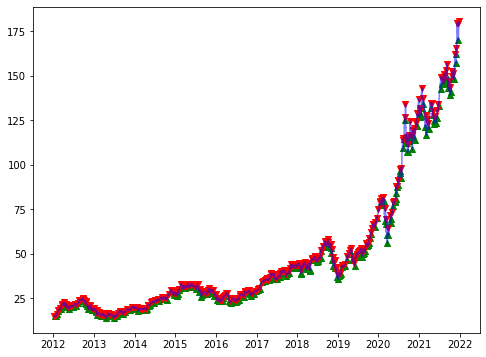

In [24]:
plot_labels(data)

In [25]:
data = data.dropna()

## Train-Val-Test Split

We would need to create a training, validation, and test set. The training set would need to have more data then the validation and test set. For each training iteration, the model will learn the weights of the features using the training set and test these weights on the validation set. The validation set is needed to test if the model is over fitting to the training set. We can determine this through the loss function which will be explained in greater detail below in the training section. After all the training is done, the model is then ran on the test set data.

Because of the sequential order of time series data, we can no do a traditional train-test split. This is because a regular train-test split would shuffle the data points and cause them to be out order. We want the model to detect any seasonality and trend. In order to do that, we would need to partition the unshuffled data set.

 Below, we have stated that the first 60% of the data set would be the training data set, the next 10% would be the validation set and the remaining ~30% would be the test set.

In [26]:
train_size = int(len(data)*.6)
val_size = int(len(data) *.1)
test_size = len(data)-train_size-val_size

Using this code, we can see how the data is split. The first section is training. The second section is validation. The third section is the test.

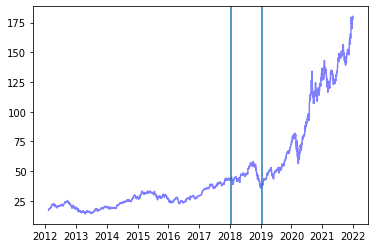

In [27]:
plt.plot(data["Close"], color = "blue", alpha = .5)
# Get the X values that would have lines to symbolize splitting of the data
xcoords = [data.index[train_size], data.index[train_size+val_size]]
for xc in xcoords:
    plt.axvline(x=xc)

In [28]:
train_df = data[:train_size]
val_df = data[train_size: train_size+val_size]
test_df = data[train_size+val_size:]

# Normalization

Because of the big differences in feature sizes where one number may ne in the hundred millions, while other numbers are single digits, we would need to normalize. Without normalization, bigger numbers in certain features will dominate the model and have a greater impact compared to smaller numbers in other features. We can normalize using a MinMaxScaler for each feature column. MinMaxScaler: X_norm  = (X - Xmin)/(Xmax – Xmin). This will allow all the features to have the same weights throughout the model

In [29]:
# All columns except the target (last one) will be normalized
norm_cols = list(train_df.columns)[:-1]

In [30]:
# Normalize using the training dataframe
scaler = MinMaxScaler()
train_df[norm_cols] = scaler.fit_transform(train_df[norm_cols])
# Fit training normalization
val_df[norm_cols] = scaler.transform(val_df[norm_cols])
test_df[norm_cols] = scaler.transform(test_df[norm_cols])

C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Data Preprocessing

In order to insert data into the network, we would have to create the necessary inputs. We plan to use an LSTM model. For the LSTM, we need to send the features of the last X days. Using the patterns and trends seen in the last X day's models, the LSTM can predict an output.

In [31]:
# Split into features and target variables
train_x, train_y = train_df.iloc[:,:-1],train_df.iloc[:,-1]
val_x, val_y = val_df.iloc[:,:-1],val_df.iloc[:,-1]
test_x, test_y = test_df.iloc[:,:-1],test_df.iloc[:,-1]

Window size refers to the number of days used as input into the LSTM model.

In [32]:
WINDOW_SIZE = 30

The function below creates input data that use the last X days, Returns list of lists. The inner lists contain the features for each of the last X days.


In [33]:
def create_sequences(data, window = WINDOW_SIZE):
    '''
    Structure the data in a way that can be inputted into model

        Parameters:
                data (DataFrame): asset data
                window_size (int): number of days to put back into

        Returns:
                (list): list of lists; inner list is list of previous days
    '''
    seq = []
   
    for i in range(len(data)-window):
        record = []
        for j in range(window):
            
            record.append(data.iloc[i+j].values)
        seq.append(record)

    
    return seq 




The function below creates input data that use the last X days and returns a list of lists. The inner lists contain the features for each of the last X days.


In [34]:
def create_model_input(seq, y, window=WINDOW_SIZE):
    '''
    Combine the last X days features with the associated target value 
        Parameters:
                seq (list): contains lsit of lists of previous days sequences 
                window_size (int): number of days to ignore in beginning of target list

        Returns:
                (list): list of 1. input tensors  of previous data's features and 2. tensor of target value
    '''
    # ignore previous days targets to start input
    y = y[window:]
    assert len(seq) == len(y)
    
    # Convert input list to tensors
    seq_tensor = [torch.tensor(l) for l in seq]
    # Convert target to tensor
    y_tensor = [torch.tensor(l).unsqueeze(0) for l in y]
    # Put the tensors togethers
    inout_seq = list(zip(seq_tensor, y_tensor))
    return inout_seq
    

In [35]:
train_seq = create_sequences(train_x)
train_inout_seq = create_model_input(train_seq, train_y)

val_seq = create_sequences(val_x)
val_inout_seq = create_model_input(val_seq, val_y)

test_seq = create_sequences(test_x)
test_inout_seq = create_model_input(test_seq, test_y)

In [36]:
train_inout_seq[0]

(tensor([[0.0998, 0.2479, 0.0330, 0.0483, 0.0318, 0.2902, 0.0330, 0.0413, 0.0255,
          0.8897, 0.0545, 0.0199, 0.0558, 0.0229, 0.7597, 0.0468, 0.3669],
         [0.1189, 0.5741, 0.0374, 0.0587, 0.0298, 0.3417, 0.0374, 0.0489, 0.0267,
          0.9445, 0.0616, 0.0251, 0.0633, 0.0268, 0.7843, 0.0479, 0.4102],
         [0.1192, 0.4009, 0.0419, 0.0670, 0.0301, 0.3754, 0.0419, 0.0554, 0.0292,
          0.9452, 0.0677, 0.0300, 0.0681, 0.0307, 0.8003, 0.0413, 0.3633],
         [0.1298, 0.3228, 0.0470, 0.0762, 0.0309, 0.4110, 0.0470, 0.0627, 0.0321,
          0.9692, 0.0746, 0.0354, 0.0741, 0.0348, 0.8203, 0.0479, 0.3759],
         [0.1378, 0.2839, 0.0523, 0.0859, 0.0313, 0.4506, 0.0523, 0.0704, 0.0350,
          0.9846, 0.0817, 0.0411, 0.0805, 0.0390, 0.8403, 0.0468, 0.3361],
         [0.1241, 1.0000, 0.0566, 0.0913, 0.0342, 0.4612, 0.0566, 0.0752, 0.0386,
          0.7985, 0.0855, 0.0452, 0.0850, 0.0426, 0.8375, 0.0426, 0.3404],
         [0.1294, 0.6154, 0.0612, 0.0965, 0.0381, 0.4671, 

## The Model (LSTM)
An LSTM (Long Short Term Memory) network is a type of RNN (Recurrent Neural Network). The LSTM model does a great job at using older and more recent data to make predictions about the current state because it has 3 gates in which data flows through: an input gate, an output gate and a forget gate. This forget gate allows the network to emphasis information that is more important and needed for predictions. This gate also determines how much of the sequence input data should be used for the prediction and how much should be remembered for the next prediction. This is more advanced than an RNN as an RNN does not have this gate. RNNs are able to use long inputs of data but suffer from the exploding and vanishing gradients effect when back propagating through the network This  Because of this feature of the forget/memory gate, it is a very popular network to use on time-series data.

PyTorch provides a very good LSTM model. We can use this PyTorch LSTM model as a part of our overall network. The LSTM model has input, output, number of LSTM layers, and dropout parameters. the input and output layers are standard for network modules. The LSTM layer parameter explains how many LSTM should be used on the input data recurrently. The dropout parameter can be used to remove/ignore nodes when training to explore other features. This would reduce chances of the model over-fitting on the training data. In the LSTM module, it can only be applied if there are more than 1 LSTM layer as dropout would act between LSTM layers.

For classification, the input layer would have the number of features, which in this case is 17. The output layer would be 1 because we are predicting the probability of 3 class values representing buy, sell, or hold.


In [37]:
NUM_FEATURES = 17
BATCH_SIZE = 1
class NetworkClassifier(torch.nn.Module):
    def __init__(self, input_size = NUM_FEATURES, hidden_size = 128, output_size = 3, batch_size = BATCH_SIZE, dropout = 0.2, num_layers=2):
        super().__init__()
        self.input_size = input_size #num of features
        self.hidden_size = hidden_size
        self.output_size = output_size    
        self.batch_size = batch_size
        self.num_layers = num_layers  

        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers, dropout=dropout)
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        # a new hidden-state (the LSTM requires, unlike RNNs, two hidden-states in a tuple)
        

    def forward(self, input_seq):
        hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size), torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
        lstm_out, hidden = self.lstm(input_seq, hidden) 
        out = self.linear(hidden[0])
        # for classifiction we mostly just want the last one  
        return out[-1]

## Training Loop

This training loop uses a set of hyperparameters to see which parameters lead to the lowest training and validation loss without overfitting. The hyperparameters that need to be tuned are the learning rate (lr), hidden size, dropout, number of layers, and the optimizer used. 

The learning rate adjusts the amount that is iterated towards a minimum of a loss function. If the learning rate is too high then it keep skipping the minimum and never reach it. If it is too low, then it would take too long to train or get stuck at a local minimum. This is why we need to tune it.

The hidden size refers to the number of neurons to be set for the hidden layer. This would slightly change the network in allowing to to break up the features into components of different weights. More hidden sizes means more weights to be assigned and tunned and therefore, leads to more time to train. More hidden sizes also a means a more complex model which can be prone to overfitting. Less hidden sizes means that the model may have trouble weighing the features properly. 

Dropout was explained above in the model section. If there is too much dropout, then the model will throw away too much information about the features and not learn much. If there is too little dropout, then the model may overfit to the training data.

The number of layers was also explained above. More number of layers makes the model more complex and can overfit. Less number of layers could make the feature weights harder to learn.

Lastly, the optimizer used can be tuned. There are 2 main optimizers: Stochastic Gradient Descent (SGD) and Adam. SGD is know to generalize well and Adam is known to be more specific to the data. SGD is also know to converge faster than Adam. Both of these optimizers can lead to different results for loss and therefore we should try both.

We also want the model to predict a buy/sell more often than a hold. If the classes were equal weighted, then the model will find that the lowest loss value would be obtained by predicting hold or no action at every time step. This is not useful. In order to avoid this, we can throw in class weights to our loss function (Cross Entropy). These weights can be computed by using the frequency of the class in the training set. This means that the lower frequency of the class, the higher importance of predicting it in training, the higher the weight.

Usually for training models, we would oversample using SMOTE, but that would much harder with a time-series dataset where values must be predicted based on the last X days of data points.

In [39]:
# Use the count of the classes to determine the weights
class_weights = [1/(train_df["Target"].value_counts()[class_num]) for class_num in range(3)]
class_weights=torch.tensor(class_weights,dtype=torch.float)

In [ ]:
epochs = 40

hidden_sizes = [32, 64, 128, 256]
n_dropouts = [0, .2, .4, .6]
num_layers = [1,2,3,4]

lrs = [,1,.01,.001,.0001]
opt_texts = ["adam", "sgd"]


#stopped at: hs_128_do_0.2_nl_2_lr_0.0001_opt_adam_03-04-1053
##  Hyper parameter tuning
# For each parameter combination (grid search)
for hidden_size in hidden_sizes:
    for dropout in n_dropouts:   
        for num_layer in num_layers:
            # Create the model with the specific parameters
            model = NetworkClassifier(hidden_size=hidden_size, dropout=dropout, num_layers=num_layer)
            
            for lr in lrs:
                for opt_text in opt_texts:
                    # Pick optimizer
                    if opt_text == "adam":
                        opt = torch.optim.Adam(model.parameters(),lr=lr)
                    else:
                        opt = torch.optim.SGD(model.parameters(),lr=lr)

                    loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)
                    
                    # Long name created for tensorboard and to save the model in order to pull again if best
                    log_name = 'mc_hs_' + str(hidden_size) + "_do_" + str(dropout) + "_nl_"+ str(num_layer) + "_lr_" + str(lr) + "_opt_" + opt_text + "_" + datetime.now().strftime("%m-%d-%H%M")
                    
                    # Begin Training
                    for epoch in range(epochs):
                        print("epoch", epoch)
                        train_loss_total = 0
                        
                        # Add to Tensorboard
                        train_logger = tb.SummaryWriter('./writer/' + log_name + '/train', flush_secs = 1)
                        # For each training instance/example
                        for i, (x, y) in enumerate(train_inout_seq):
                            # Set model to training mode to adjust weights
                            model.train()
                            # Zero out the gradients
                            opt.zero_grad()
                            
                            # Get the input data in formatted
                            x = x.view(len(x), 1, -1)
                            # Send input data into model and get outputs
                            out = model(x.float())
                            # The highest probilility class is the selected class 
                            y_pred = torch.argmax(out, dim=1)
                            # Calculate the loss by comparing to original true class
                            loss = loss_func(out,y.type(torch.LongTensor))
                            # Back proporgate and update weights
                            loss.backward()
                            # Move down gradient using learning rate
                            opt.step()
                            # Add loss to overall training loss
                            train_loss_total += loss.item()
                        
                        # Set the model in evaluation model to not adjust weights
                        model.eval()
                        # Add validation to tensorboard
                        val_logger = tb.SummaryWriter('./writer/' + log_name + '/val', flush_secs = 1)
                        val_loss_total = 0
                        # For each validation sample
                        for i, (x, y) in enumerate(val_inout_seq):
                            # Get the output
                            out = model(x.view(len(x), 1, -1).float())
                            # Find the loss compared to true value
                            loss = loss_func(out,y.type(torch.LongTensor))
                            # Add loss to overall validation loss
                            val_loss_total += loss.item()

                        # Get the average loss values
                        avg_train_loss = train_loss_total/len(train_inout_seq)
                        avg_val_loss = val_loss_total/len(val_inout_seq)
                        
                        print(avg_train_loss, avg_val_loss)
                        # Add to tensorboard graphs for each epoch
                        train_logger.add_scalar("Loss_train", avg_train_loss, epoch)
                        val_logger.add_scalar("Loss_val", avg_val_loss, epoch)
                    
                    # Save the trained model
                    torch.save(model, "models/%s.pt" % log_name)  


## Model Selection

In order to find the best model, we would need to look at all of the model trained and see their loss values. The lower the loss value, the better the model is on the dataset. However, both the training and validation loss for the same model must decrease together. If the training loss is decreasing while the validation loss in increasing, then we know that the model is over-fitting. To catch this over-fitting, we split the data into a training and validation set.

We can use tensorboard to see how well the model has trained and visualize loss value. In the image below, we see tensorboard plot a certain model. This model has a hidden size of 129, dropout of 0.2, number of layers of 1, learning rate of 0.01, and an optimizer of adam. We see that both the training loss and validation loss is decreasing during the same set of of time steps. We also see that sharp increases in loss are sene in both too. This is not an over-fitted model, however, this may not be the best model to use. To find the best model, we would need to find the lowest train/val loss for a single model while the model is not over-fitting. 

![tensorboard](report_images/tensorboard.png "Example of Tensorboard")

In [ ]:
# model = torch.load("MODEL_FILE_NAME.pt")

## Results

Using one of the better trained model, we can visualize the classification results. We can compare the model's predicted values to the true values.

NOTE: Graph shown below is from previous training runs with short amounts of dates (01/2021 - 01/2022) and a shorter window size (7 days). The reason why I am showing this graph is that training and hyperparameter tuning is very slow with over 10 years of data. The conclusion of my report follows these results. More training and time is needed.

In [51]:
def plot_preds(df_set, preds, window_size = WINDOW_SIZE, show_true=False):
    '''
    Combine the last X days features with the associated target value 
        Parameters:
                df_set (DataFrame): Asset information 
                preds (list): prediction list
                window_size (int): number of previous X in each sample
                show_true (bool): Flag to plot true signals as well

    '''

    df = df_set.copy()
    # Get true Buy and Sell price points
    df["Buy"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 1.0 else np.nan for i in range(len(df["Target"]))]
    df["Sell"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 0.0 else np.nan for i in range(len(df["Target"]))]

    # Get prediction price points
    df["Pred Buy"] = [np.nan] * window_size + [df.iloc[i+window_size]["Close"] if preds[i] == 1 else np.nan for i in range(len(preds))]
    df["Pred Sell"] = [np.nan] * window_size + [df.iloc[i+window_size]["Close"] if preds[i] == 0 else np.nan for i in range(len(preds))]

    # Create a plot of close prices
    fig = plt.figure(figsize=(8, 6))
    plt.plot(df["Close"], color = "blue", alpha = .5)
    
    # Plot the true values on the close price line
    if show_true:
        # Green up arrow
        if(not df["Buy"].isnull().all()):
            plt.scatter(df.index, df["Buy"], color = 'green', marker="^", alpha=1)
        # Red down arrow
        if(not df["Sell"].isnull().all()):
            plt.scatter(df.index, df["Sell"], color = 'red', marker="v", alpha=1)
    # Plot prediction values on the close price line
    if(not df["Pred Buy"].isnull().all()):
        # Purple up arrow
        plt.scatter(df.index, df["Pred Buy"], color = 'purple', marker="^", alpha=1)
    if(not df["Pred Sell"].isnull().all()):
        # Orange down arrow
        plt.scatter(df.index, df["Pred Sell"], color = 'orange', marker="v", alpha=1)
    

    plt.show() 
   
    plt.close(fig)

Here is the plot of the training set predictions.

In [ ]:

model.eval()

preds = []

for i, (x, y) in enumerate(train_inout_seq):
    preds.append(torch.argmax(model(x.view(len(x), 1, -1).float())).item())

print(set(preds))

plot_preds(train_df,preds)

![mc_train](report_images/mc_train.png "Multiclass Train Results")

Here is the plot of the validation set predictions.

In [ ]:
model.eval()

preds = []

for i, (x, y) in enumerate(val_inout_seq):
    preds.append(torch.argmax(model(x.view(len(x), 1, -1).float())).item())


print(set(preds))
plot_preds(val_df,preds)
    

![mc_val](report_images/mc_val.png "Multiclass Validation Results")

Here is a plot of the test set predictions.

In [ ]:
model.eval()

preds = []

for i, (x, y) in enumerate(test_inout_seq):
    preds.append(torch.argmax(model(x.view(len(x), 1, -1).float())).item())

plot_preds(test_df,preds, show_true=True)

![mc_test](report_images/mc_test.png "Multiclass Test Results")

## Model Discussion

We see that the training set did really well with predicting the data compared to the validation and test set. This is expected as the model overfit. The model did very poorly on the validation and test set as it had issues predicting the correct buy and sell points.

## Model Conclusion

After many iterations of training and testing, we found that this model is not optimal for this task. It is difficult to classify minority classes while not overfitting to the training model. We also saw that this could be because of the loss function. Cross entropy loss does not take into account time steps; so this means that if the model prediction was off by one day or 100 days, the loss function would compute the same value. We tried to created a custom loss function in PyTorch, but was not possible to throw in the index of the training sample and compare that to the predicted value's index as well. If there was a way to allow the number of days to be included in a classification loss function, then this task would be much easier to train and predict.

My next thought was how to remove the majority class (hold/do nothing). The way we could remove these is only predict 2 values that will always exist between every time step: up/down.

## Approach #2: Binary Classification

Our goal was to make the model have more classification action classes to pick from. Every day in the stock markets, prices can go up or down. Using the next day's closing price, we can label the true class value to be either an increase in price (up) or a decrease in price (down). Our trading strategy would be to buy at every predicted increase in price and sell at every predicted decrease in price.

In [68]:
def get_labels(data):
    '''
    Calculate all true labels/targets of the dataset

        Parameters:
                data (DataFrame): asset data

        Returns:
                (DateFrame): Asset data with new infomation
    '''
    counter_row = 0 #counterRow
    num_periods = len(data) #numberOfDaysInFile
    labels = []

    print(data.shape)

    while(counter_row < num_periods-1):
        # Increase in price
        if (data.iloc[counter_row]["Close"] < data.iloc[counter_row+1]["Close"]):
            labels.append(1) #it goes up
        # Decrease in price
        else:
            labels.append(0) #it goes down
        
        counter_row+=1

    data.drop(data.tail(1).index,inplace=True)        

    data["Target"] = labels
    data["Target"] =  data["Target"]
    return data

In [69]:
symbol = "AAPL"

data = get_data(symbol)
data = get_TA(data)

# current = get_current_headlines(symbol)
# past = get_past_headlines(symbol)

# news = pd.concat([current, past])

# data = get_sentiment(data, news)

data = get_labels(data)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(2516, 17)


,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,302220800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.500000,1.960,1
2012-01-04,14.765714,260022000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.699997,1.995,1
2012-01-05,14.929643,271269600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.039993,1.993,1
2012-01-06,15.085714,318292800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.709999,1.961,0
2012-01-09,15.061786,394024400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.020004,1.960,1


## Visualize True Labels

We see that every upward trend in price has a lot of green upward arrows and every downward trend in price has a lot of red downward arrows.

In [70]:
def plot_labels(data, symbol):

    df = data.copy()
    # Buy if there is an increase
    df["Buy"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 1.0 else np.nan for i in range(len(df["Target"]))]
    # Sell if there is a decrease
    df["Sell"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 0.0 else np.nan for i in range(len(df["Target"]))]

    fig = plt.figure(figsize=(8, 6))
    plt.plot(df["Close"], color = "blue", alpha = .5)
    
    if(not df["Buy"].isnull().all()):
        plt.scatter(df.index, df["Buy"], color = 'green', marker="^", alpha=1)
    if(not df["Sell"].isnull().all()):
        plt.scatter(df.index, df["Sell"], color = 'red', marker="v", alpha=1)

    plt.show() 
    plt.close(fig)

In [71]:
data = data.dropna()

## Train-Val-Test Split

In [72]:
train_size = int(len(data)*.6) #60% training
val_size = int(len(data) *.1) #10% validation
test_size = len(data)-train_size-val_size # rest ~30% test

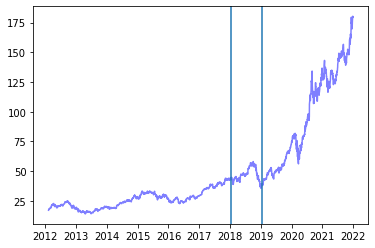

In [73]:
plt.plot(data["Close"], color = "blue", alpha = .5)
xcoords = [data.index[train_size], data.index[train_size+val_size]]
for xc in xcoords:
    plt.axvline(x=xc)

In [74]:
train_df = data[:train_size]
val_df = data[train_size: train_size+val_size]
test_df = data[train_size+val_size:]

# Normalization

In [75]:
norm_cols = list(train_df.columns)[:-1]

In [76]:
scaler = MinMaxScaler()
train_df[norm_cols] = scaler.fit_transform(train_df[norm_cols])
val_df[norm_cols] = scaler.transform(val_df[norm_cols])
test_df[norm_cols] = scaler.transform(test_df[norm_cols])

C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [77]:
train_x, train_y = train_df.iloc[:,:-1],train_df.iloc[:,-1]
val_x, val_y = val_df.iloc[:,:-1],val_df.iloc[:,-1]
test_x, test_y = test_df.iloc[:,:-1],test_df.iloc[:,-1]

## Construct Model Inputs

In [78]:
train_seq = create_sequences(train_x)
train_inout_seq = create_model_input(train_seq, train_y)

val_seq = create_sequences(val_x)
val_inout_seq = create_model_input(val_seq, val_y)

test_seq = create_sequences(test_x)
test_inout_seq = create_model_input(test_seq, test_y)

## The Model (LSTM)

For binary classification, the input layer would have the number of features, which is this case is 17. The output layer would be one because we are predicting the probability of 2 class values representing up or down.


In [79]:
NUM_FEATURES = 17
BATCH_SIZE = 1
class NetworkClassifier(torch.nn.Module):
    def __init__(self, input_size = NUM_FEATURES, hidden_size = 128, output_size = 2, batch_size = BATCH_SIZE, dropout = 0.2, num_layers=2):
        super().__init__()
        self.input_size = input_size #num of features
        self.hidden_size = hidden_size
        self.output_size = output_size    
        self.batch_size = batch_size
        self.num_layers = num_layers  

        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers, dropout=dropout)
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, input_seq):
        hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size), torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
        lstm_out, hidden = self.lstm(input_seq, hidden) 
        out = self.linear(hidden[0])
        return out[-1]

## Training Loop

In [ ]:
epochs = 40

hidden_sizes = [128, 256]
n_dropouts = [0, .2, .4, .6]
num_layers = [1,2,3,4]

lrs = [.01,.001,.0001]
opt_texts = ["adam", "sgd"]

##  Hyper parameter tuning
# For each parameter combination (grid search)
for hidden_size in hidden_sizes:
    for dropout in n_dropouts:   
        for num_layer in num_layers:
            # Create the model with the specific parameters
            model = NetworkClassifier(hidden_size=hidden_size, dropout=dropout, num_layers=num_layer)
            
            for lr in lrs:
                for opt_text in opt_texts:
                    # Pick optimizer
                    if opt_text == "adam":
                        opt = torch.optim.Adam(model.parameters(),lr=lr)
                    else:
                        opt = torch.optim.SGD(model.parameters(),lr=lr)

                        loss_func = torch.nn.CrossEntropyLoss()
                        
                        # Long name created for tensorboard and to save the model in order to pull again if best
                        log_name = 'bc_hs_' + str(hidden_size) + "_do_" + str(dropout) + "_nl_"+ str(num_layer) + "_lr_" + str(lr) + "_opt_" + opt_text + "_" + datetime.now().strftime("%m-%d-%H%M")
                        
                        # Begin Training
                        for epoch in range(epochs):
                            print("epoch", epoch)
                            train_loss_total = 0
                            
                            # Add to Tensorboard
                            train_logger = tb.SummaryWriter('./writer/' + log_name + '/train', flush_secs = 1)
                            # For each training instance/example
                            for i, (x, y) in enumerate(train_inout_seq):
                                # Set model to training mode to adjust weights
                                model.train()
                                # Zero out the gradients
                                opt.zero_grad()
                                
                                # Get the input data in formatted
                                x = x.view(len(x), 1, -1)
                                # Send input data into model and get outputs
                                out = model(x.float())
                                # The highest probilility class is the selected class 
                                y_pred = torch.argmax(out, dim=1)
                                # Calculate the loss by comparing to original true class
                                loss = loss_func(out,y.type(torch.LongTensor))
                                # Back proporgate and update weights
                                loss.backward()
                                # Move down gradient using learning rate
                                opt.step()
                                # Add loss to overall training loss
                                train_loss_total += loss.item()
                            
                            # Set the model in evaluation model to not adjust weights
                            model.eval()
                            # Add validation to tensorboard
                            val_logger = tb.SummaryWriter('./writer/' + log_name + '/val', flush_secs = 1)
                            val_loss_total = 0
                            # For each validation sample
                            for i, (x, y) in enumerate(val_inout_seq):
                                # Get the output
                                out = model(x.view(len(x), 1, -1).float())
                                # Find the loss compared to true value
                                loss = loss_func(out,y.type(torch.LongTensor))
                                # Add loss to overall validation loss
                                val_loss_total += loss.item()

                            # Get the average loss values
                            avg_train_loss = train_loss_total/len(train_inout_seq)
                            avg_val_loss = val_loss_total/len(val_inout_seq)
                            print(avg_train_loss, avg_val_loss)
                            # Add to tensorboard graphs for each epoch
                            train_logger.add_scalar("Loss_train", avg_train_loss, epoch)
                            val_logger.add_scalar("Loss_val", avg_val_loss, epoch)
                        
                        # Save the trained model
                        torch.save(model, "models/%s.pt" % log_name)  


In [ ]:
# model = torch.load("MODEL_FILE_NAME.pt")

## Results

NOTE: displayed runs are also from previous test runs with smaller amounts of training data. Please refer to Results markdown cell for multi-classification for more details.

In [ ]:
model.eval()

preds = []

for i, (x, y) in enumerate(train_inout_seq):
    preds.append(torch.argmax(model(x.view(len(x), 1, -1).float())).item())

print(set(preds))

plot_preds(train_df,preds,show_true=False)

![bc_test](report_images/bc_test.png "Binary Class Train Results")

In [ ]:
model.eval()

preds = []

for i, (x, y) in enumerate(val_inout_seq):
    preds.append(torch.argmax(model(x.view(len(x), 1, -1).float())).item())


print(set(preds))
plot_preds(val_df,preds)
    

![bc_val](report_images/bc_val.png "Binary Class Val Results")

In [ ]:
model.eval()

preds = []

for i, (x, y) in enumerate(test_inout_seq):
    preds.append(torch.argmax(model(x.view(len(x), 1, -1).float())).item())

plot_preds(test_df,preds, show_true=True)

![bc_test](report_images/bc_test.png "Binary Class Test Results")

## Model Discussion

We see that the training set did really well with predicting the data compared to the validation and test set. This is expected as the model overfit. The model did very poorly on the validation and test set as it had issues predicting the correct buy and sell points just like it did in the Multi class classification model.

## Model Conclusion

This model was better but still not optimal than the multiclass classification model. We see that it has moments that it predicts the same class over and over again in a series of steps. I feel that this could be solved if given more time and resources for training. 

After working on this model, my next step was to instead of predicting direct trading decisions, we can use a machine learning model to give us prediction that we can use as a way to compute trading decisions. The binary classification model can suffer random shocks to the market that allow the price to randomly increase between days. This is not as helpful to the model as the model needs to see a trend of numbers and then needs to predict the next action/number. This leads us to regression.

## Approach #3: Regression

Our goal was to move away from making the model tell what the trader should do, but instead, allow the trader to use the information predicted by the model to make it's own trading decisions. In order to do this, we can have the model predict next day's closing price given the last X days of data. If there is a significant increase in predicted price, then we can buy. If there is a significant decrease in predicted price, then we sell.

We can get the target values by looking at the next day's close price, assuming lag of 1.

## Get Targets

In [89]:
def get_labels(data, lag = 1):
    '''
    Calculate all true labels/targets of the dataset

        Parameters:
                data (DataFrame): asset data
                window_size (int): number of days to find mins and maxes

        Returns:
                (DateFrame): Asset data with new infomation
    '''
    counter_row = 0 #counterRow
    num_periods = len(data) #numberOfDaysInFile
    labels = []

    print(data.shape)

    while(counter_row < num_periods-lag):
        labels.append(data.iloc[counter_row+lag]["Close"])
        counter_row+=1

    data.drop(data.tail(lag).index,inplace=True)        

    data["Target"] = labels
    data["Target"] =  data["Target"]
    return data

In [90]:
symbol = "AAPL"

data = get_data(symbol)
data.head()

data = get_TA(data)

# current = get_current_headlines(symbol)
# past = get_past_headlines(symbol)

# news = pd.concat([current, past])

# data = get_sentiment(data, news)

data = get_labels(data)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(2516, 17)


,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,302220800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.500000,1.960,14.765714
2012-01-04,14.765714,260022000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.699997,1.995,14.929643
2012-01-05,14.929643,271269600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.039993,1.993,15.085714
2012-01-06,15.085714,318292800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.709999,1.961,15.061786
2012-01-09,15.061786,394024400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.020004,1.960,15.115714


In [91]:
data = data.dropna()

## Train-Val-Test Split

In [92]:
train_size = int(len(data)*.6)
val_size = int(len(data) *.1)
test_size = len(data-train_size-val_size)

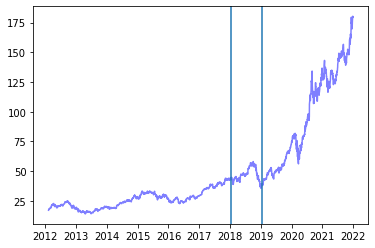

In [93]:
plt.plot(data["Close"], color = "blue", alpha = .5)
xcoords = [data.index[train_size], data.index[train_size+val_size]]
for xc in xcoords:
    plt.axvline(x=xc)

In [94]:
train_df = data[:train_size]
val_df = data[train_size: train_size+val_size]
test_df = data[train_size+val_size:]

## Normalization

Because this is a regression task and we are trying to predict big numbers, we would need to normalize that target prices as well. If the prices were between 0-1, then the model would be able to adjust it's weights better and therefore train better.

In [95]:
scaler = MinMaxScaler()
scalerY = MinMaxScaler()

feature_cols = list(train_df.columns)[:-1]

train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# Normalize the targets as well
train_df[["Target"]] = scalerY.fit_transform(train_df[["Target"]])
val_df[["Target"]] = scalerY.transform(val_df[["Target"]])
test_df[["Target"]] = scalerY.transform(test_df[["Target"]])





C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\rudra\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [96]:
# Split into features and target variables
train_x, train_y = train_df.iloc[:,:-1],train_df.iloc[:,-1]
val_x, val_y = val_df.iloc[:,:-1],val_df.iloc[:,-1]
test_x, test_y = test_df.iloc[:,:-1],test_df.iloc[:,-1]

## Data Preprocessing

In [97]:
train_seq = create_sequences(train_x)
train_inout_seq = create_model_input(train_seq, train_y)

In [98]:
val_seq = create_sequences(val_x)
val_inout_seq = create_model_input(val_seq, val_y)

In [99]:
test_seq = create_sequences(test_x)
test_inout_seq = create_model_input(test_seq, test_y)

## The Model (LSTM)
For regression, we would need to have an input linear layer which can sent data to the LSTM layer and then have an output linear layer. The input layer would have the number of features, which is this case is 17. The output layer would be one because we are predicting a single value representing the closing price of the next day.


In [101]:
NUM_FEATURES = 17
BATCH_SIZE = 1
class NetworkReg(torch.nn.Module):
    def __init__(self, input_size = NUM_FEATURES, hidden_size = 128, output_size = 1, batch_size = BATCH_SIZE, dropout = 0.2, num_layers=2):
        super().__init__()
        self.input_size = input_size #num of features
        self.hidden_size = hidden_size
        self.output_size = output_size    
        self.batch_size = batch_size
        self.num_layers = num_layers  

        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.lstm = torch.nn.LSTM(self.hidden_size,  hidden_size=self.hidden_size, num_layers = self.num_layers, dropout=dropout)
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, input_seq):
        x = self.linear_1(input_seq)
        x = self.relu(x)
        hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size), torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

        lstm_out, hidden = self.lstm(x, hidden)
        
        out = self.linear(hidden[0])
        return out[-1]

In [ ]:
epochs = 40

hidden_sizes = [128, 256]
n_dropouts = [0, .2, .4, .6]
num_layers = [1,2,3,4]

lrs = [.01,.001,.0001]
opt_texts = ["adam", "sgd"]

# epochs = 35
# lrs = [.0001]
# hidden_sizes =[ 64]
# n_dropouts =[.2]
# num_layers = [2]
# opt_texts = ['adam']

#stopped at: hs_128_do_0.2_nl_2_lr_0.0001_opt_adam_03-04-1053
##  Hyper parameter tuning
# For each parameter combination (grid search)
for hidden_size in hidden_sizes:
    for dropout in n_dropouts:   
        for num_layer in num_layers:
            # Create the model with the specific parameters
            model = NetworkReg(hidden_size=hidden_size, dropout=dropout, num_layers=num_layer)
            
            for lr in lrs:
                for opt_text in opt_texts:
                    # Pick optimizer
                    if opt_text == "adam":
                        opt = torch.optim.Adam(model.parameters(),lr=lr)
                    else:
                        opt = torch.optim.SGD(model.parameters(),lr=lr)

                    loss_func = torch.nn.MSELoss()
                    
                    # Long name created for tensorboard and to save the model in order to pull again if best
                    log_name = 'reg_hs_' + str(hidden_size) + "_do_" + str(dropout) + "_nl_"+ str(num_layer) + "_lr_" + str(lr) + "_opt_" + opt_text + "_" + datetime.now().strftime("%m-%d-%H%M")
                    
                    # Begin Training
                    for epoch in range(epochs):
                        print("epoch", epoch)
                        train_loss_total = 0
                        
                        # Add to Tensorboard
                        train_logger = tb.SummaryWriter('./writer/' + log_name + '/train', flush_secs = 1)
                        # For each training instance/example
                        for i, (x, y) in enumerate(train_inout_seq):
                            opt.zero_grad()
                            x = x.view(len(x), 1, -1)

                            out = model(x.float())
                            loss = loss_func(out,y.view(-1,1))

                            loss.backward()
                            opt.step()

                            train_loss_total += loss.item()

                        
                        # Set the model in evaluation model to not adjust weights
                        model.eval()
                        # Add validation to tensorboard
                        val_logger = tb.SummaryWriter('./writer/' + log_name + '/val', flush_secs = 1)
                        val_loss_total = 0
                        # For each validation sample
                        for i, (x, y) in enumerate(val_inout_seq):
                            
                            out = model(x.view(len(x), 1, -1).float())
                            loss = loss_func(out,y.view(-1,1))

                            val_loss_total += loss.item()

                        # Get the average loss values
                        avg_train_loss = train_loss_total/len(train_inout_seq)
                        avg_val_loss = val_loss_total/len(val_inout_seq)

                        print(avg_train_loss)
                        print(avg_val_loss)
                        
                        # Add to tensorboard graphs for each epoch
                        train_logger.add_scalar("Loss_train", avg_train_loss, epoch)
                        val_logger.add_scalar("Loss_val", avg_val_loss, epoch)
                    
                    # Save the trained model
                    torch.save(model, "models/%s.pt" % log_name)  


In [141]:
model = torch.load("models/reg_hs_64_do_0.2_nl_2_lr_0.0001_opt_adam_05-09-2259.pt")

## Prediction

In order to see how well our model predicts, we need to visualize the data and its predictions. We need to also assign how a bot would trade based on the predicted changes in price. This can be done by creating thresholds of predict changes and using buy/sell signals based on if the price changes past those specified thresholds. In this case, the default threshold is .15% on both sell and buy. This means that if the predicted price has a higher than .15% percent change from the previous price, then we would buy (if positive increase) or sell (if negative decrease). 


This function also reflects a brokage system where the bot can set a stop loss. A stop loss is a way for investors to limit the amount that they could potentially lose in an investment. It is similar to a safety net where if a trade does not go their way, they can only lose a set amount. In this case the stop_loss would be 1.5% by default. If the bot buys and the investment actually falls 1.5%, then the bot will automatically sell.


After predicting using the training, validation, and test set, we can plot the prediction regression line along with the buy and sell signals. If the sell signal was a result of a stop loss, it would be in purple.

NOTE: All graphs used the model trained above. The model used a learning rate of .0001, hidden size of 64, dropout of 0.2, number of layers of 2, and an adam optimizer. This model training was much faster than the classification models.

NOTE: The red line in the validation plot shows the regression prediction 

In [103]:
def get_trading_signals(df, window_size=WINDOW_SIZE, buy_threshold=.0015, sell_threshold=.0015, lag=0, stop_loss_percent = .015):
    '''
    Calculate all true labels/targets of the dataset

        Parameters:
                df (DataFrame): asset data
                window_size (int): number of days of previous data
                buy_threshold (float): positive percent difference min for buy signal
                sell_threshold (float): negative percent difference max for sell signal
                stop_loss_percent (float): percent loss allowed before forcing sell signal

        Returns:
                (DateFrame): Asset data with new infomation
    '''
    # Get all buys given that percent differences is greater than buy threshold
    df["Pred Buy Pred"] = [df.iloc[i]["Preds"] if df.iloc[i+lag]["percentDiff"] >= buy_threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag
    
    # Get all sells given that percent differences is less than sell threshold
    df["Pred Sell Pred"] = [df.iloc[i]["Preds"] if df.iloc[i+lag]["percentDiff"] <= -sell_threshold else np.nan for i in range(len(df)-lag)]+ [np.nan] * lag
    
    # Get true buy and sell signals using the precent difference of the true close price
    buys = [df.iloc[i]["Close"] if df.iloc[i+lag]["percentDiff"] >= buy_threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag
    sells = [df.iloc[i]["Close"] if df.iloc[i+lag]["percentDiff"] <= -sell_threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag

    pred_buy_actual = []
    pred_sell_actual = []
    stop_loss = []
    
    bought = False
    last_buy_price = np.nan
    # Trading only one share
    for i in range(len(buys)):
        # If buy signal and not bought, record buy price
        if (not math.isnan(buys[i])) and (not bought):
            pred_buy_actual.append(buys[i])
            pred_sell_actual.append(np.nan)
            stop_loss.append(np.nan)
            bought = True
            last_buy_price = buys[i]
       
        # If sell signal and bought, record sell price
        elif (not math.isnan(sells[i])) and (bought):
            pred_buy_actual.append(np.nan)
            pred_sell_actual.append(sells[i])
            stop_loss.append(np.nan)
            bought = False
        
        # If stop loss triggered and bought, record sell price
        elif(last_buy_price * (1-stop_loss_percent) > df.iloc[i]["Close"]) and (bought):
            pred_buy_actual.append(np.nan)
            pred_sell_actual.append(df.iloc[i]["Close"])
            stop_loss.append(df.iloc[i]["Close"])
            bought = False
        # Do nothing
        else:
            pred_buy_actual.append(np.nan)
            pred_sell_actual.append(np.nan)
            stop_loss.append(np.nan)
    
    df["Pred Buy Actual"] = pred_buy_actual
    df["Pred Sell Actual"] = pred_sell_actual
    df["Stop Loss"] = stop_loss

        
    return df


def plot_preds(df_set, show_signals = False, buy_threshold=.0015, sell_threshold=.0015, window_size=WINDOW_SIZE, lag=0, show_pred = True):
    
    '''
    Calculate all true labels/targets of the dataset

        Parameters:
                df_set (DataFrame): asset data
                show_signals (bool): plot buy/sell arrows
                buy_threshold (float): positive percent difference min for buy signal
                sell_threshold (float): negative percent difference max for sell signal
                window_size (int): number of days of previous data
                lag (int): how many days predicting in future
                show_pred (bool): plot the prediction regression line

    '''
    
    df = df_set.copy()
    # Un-normalize the features
    df[feature_cols] = scaler.inverse_transform(df[feature_cols])
   

    
    fig = plt.figure(figsize=(8, 6))
    # Plot true close price
    plt.plot(df["Close"], color = "blue", alpha = .5)

    # If pred regression line to be ploted, plot it in red
    if show_pred:
        df[["Preds"]] = scalerY.inverse_transform(df[["Preds"]])
        plt.plot(df["Preds"], color = "red", alpha = .5)
    
    # If signals needed, get the true vs the predicted signals
    if show_signals:
        df = get_trading_signals(df, buy_threshold=buy_threshold, sell_threshold=sell_threshold, lag=lag)
        if(not df["Pred Buy Actual"].isnull().all()):
            plt.scatter(df.index, df["Pred Buy Actual"], color = 'green', marker="^", alpha=1)
        if(not df["Pred Sell Actual"].isnull().all()):
            plt.scatter(df.index, df["Pred Sell Actual"], color = 'red', marker="v", alpha=1)
        
        if(not df["Stop Loss"].isnull().all()):
            plt.scatter(df.index, df["Stop Loss"], color = 'purple', marker="v", alpha=1)
        
        if show_pred:
            if(not df["Pred Buy Pred"].isnull().all()):
                plt.scatter(df.index, df["Pred Buy Pred"], color = 'green', marker="^", alpha=1)
            if(not df["Pred Sell Pred"].isnull().all()):
                plt.scatter(df.index, df["Pred Sell Pred"], color = 'red', marker="v", alpha=1)

    plt.show() 
    plt.close(fig)



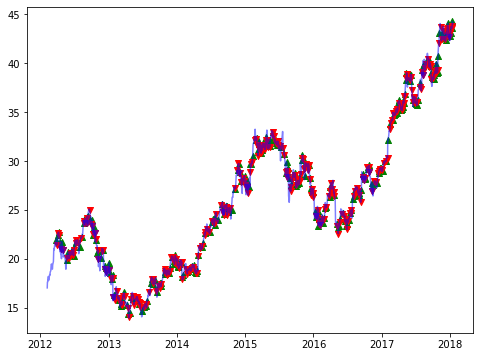

In [130]:
model.eval()
window = WINDOW_SIZE
preds = []



for i, (x, y) in enumerate(train_inout_seq):
    preds.append(model(x.view(len(x), 1, -1).float()).item())


train_df["Preds"] = [np.nan]*window + preds

train_df["percentDiff"] = train_df["Preds"].pct_change()

plot_preds(train_df, show_signals=True, buy_threshold=.0001, sell_threshold=.0001, show_pred=False)

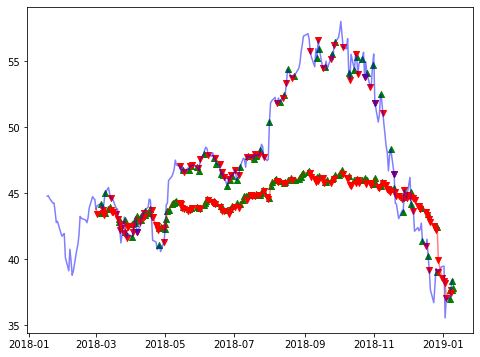

In [131]:
model.eval()

preds = []

for i, (x, y) in enumerate(val_inout_seq):
    preds.append(model(x.view(len(x), 1, -1).float()).item())

val_df["Preds"] = [np.nan]*window + preds

val_df["percentDiff"] = val_df["Preds"].pct_change()

plot_preds(val_df, show_signals=True,  buy_threshold=.0001, sell_threshold=.0001, show_pred = True)
    

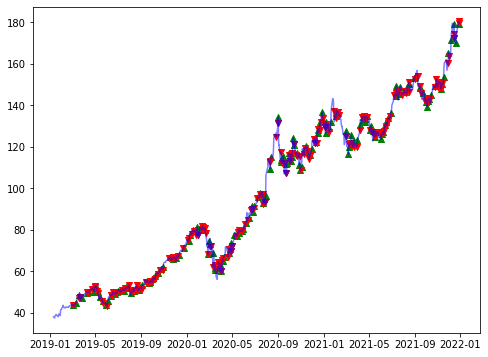

In [132]:
model.eval()

preds = []

for i, (x, y) in enumerate(test_inout_seq):
    preds.append(model(x.view(len(x), 1, -1).float()).item())

test_df["Preds"] = [np.nan]*window + preds

test_df["percentDiff"] = test_df["Preds"].pct_change()

plot_preds(test_df, show_signals=True,  buy_threshold=.0001, sell_threshold=.0001, show_pred = False)
    

## Model Evaluation

There are many ways to evaluate this model, which include comparing the number of days to true buy and sell signals, however we found that the best way would be to evaluate this model to a benchmark of buying and holding. Every trader attempts to beat the buy-and-hold method which is buying the asset at the beginning of a certain time and then not selling it and allowing it to, hopefully, appreciate in price over time. A trader want to profit off of each upward trend. So we can use the buy and sell signals along with their prices to see how much money the bot would have made and compare that to the price difference at the beginning and at the end.

In [133]:
def buy_hold_profit(df, window_size=WINDOW_SIZE):
    '''
    Calculate the buy and hold profit

        Parameters:
                df (DataFrame): asset data

        Returns:
                (float): Profit from buy and hold
    '''
    buy_hold_profit = df["Close"][-1] - df["Close"][window_size]
    return buy_hold_profit

In [134]:
def get_total_profit(data):
    '''
    Calculate total profit from all bot trades

        Parameters:
                data (DataFrame): asset data

        Returns:
                (float): Profit from trading
    '''
    profit = 0
    i = 0 
    buyIndex = -1
    sellIndex = -1

    buyCol = data.columns.get_loc("Pred Buy Actual")
    sellCol = data.columns.get_loc("Pred Sell Actual")
    closeCol = data.columns.get_loc("Close")

    # Get all indices of buy and sell and find the differences between prices
    while i < len(data):
        # Save buy index if buy
        if(not pd.isnull(data.iloc[i,buyCol]) and buyIndex == -1): 
            buyIndex = i
         # If sell, get the profit from that trade
        if(not pd.isnull(data.iloc[i,sellCol]) and buyIndex != -1):
            sellIndex = i

            # Add trade profit to total profit
            profit += (data.iloc[sellIndex,sellCol] - data.iloc[buyIndex,buyCol])
            
            buyIndex = -1
            sellIndex = -1
        # If at the end of prices and share has been bought
        if((i+1) == len(data) and buyIndex != -1):
            lastRow = -1
            # Find the last close price
            while (pd.isnull(data.iloc[lastRow, closeCol])):
                lastRow -= 1

            # Assume sold at the end of the time frame and add the profit of that trade as well
            profit += data.iloc[lastRow, closeCol] - data.iloc[buyIndex, buyCol]
        i+=1
    return profit

In [135]:
def unnormalize(df):
    '''
    Convert the normalized columns back to their original values

        Parameters:
                df (DataFrame): asset data

        Returns:
                (DataFrame): asset data un-normalized
    '''
    df_un_norm = df.copy()
    df_un_norm[feature_cols] = scaler.inverse_transform(df_un_norm[feature_cols])
    df_un_norm[["Preds"]] = scalerY.inverse_transform(df_un_norm[["Preds"]])
    return df_un_norm

In [136]:
pd.options.mode.chained_assignment = None  # default='warn'
#get rid of settingwithcopywarning message

In [137]:
print("trading: $", get_total_profit(get_trading_signals(unnormalize(train_df), buy_threshold=.0015, sell_threshold=.0015)))
print("buy & hold $", buy_hold_profit(get_trading_signals(unnormalize(train_df), buy_threshold=.0015, sell_threshold=.0015)))

trading: $ 9.632133483886717
buy & hold $ 22.642499923706055


In [138]:
print("trading: $",get_total_profit(get_trading_signals(unnormalize(val_df),  buy_threshold=.0003, sell_threshold=.0003)))
print("buy & hold $",buy_hold_profit(get_trading_signals(unnormalize(val_df),  buy_threshold=.0015, sell_threshold=.0015)))

trading: $ 1.564990997314446
buy & hold $ -5.299999237060547


In [139]:
print("trading: $",get_total_profit(get_trading_signals(unnormalize(test_df),  buy_threshold=.0003, sell_threshold=.0003)))
print("buy & hold $",buy_hold_profit(get_trading_signals(unnormalize(test_df),  buy_threshold=.0015, sell_threshold=.0015)))

trading: $ 88.53498840332033
buy & hold $ 135.79750442504883


## Results/Discussion

Honestly, the regression model does much, much better than I expected. Even though it was not able to exactly get the correct prices for each of the time steps, it was able to capture the trends as seen by the validation red regression line. Because of this, it was able to make a significant profit on more volatile data in the test set as it was still able to make a profit of $88 per share. It seems that the model seems that it is more sensitive to selling rather than buying. This is seen through the validation results as the model does a better job when trading and using the bot compared to buying and holding. This threshold of buying and selling can be adjusted for optimal results in the training and validation sets. After some more training, resources, features, and time, I believe that I can make this model close to, if not beat, the buy and hold method.

## Research Conclusion

Predicting the stock market is a very difficult tasks as there are over thousands of variables that are incorporated and many of them can not be quantified. Many banks, hedge funds, data scientists, and average retail investors try to create bots that can figure out the secrets to the market and beat it over and over again. Even the people that do get a winning strategy would not share it with the industry, making the research in this field much harder. When starting this project, I did not expect to get outstanding results. My main goal was to learn about the research and work done in this field in regards to machine learning and apply my course knowledge to a personal project. Throughout this project, I found that since I was not able to consistently beat the market, the Efficient Market Hypothesis still stands as I was not able to use historical information in order to make excess gains.

## Next Steps

Over the summer, I plan to continue researching this topic and seeing how to improve it. My next steps include:

- Long training time with better training resources (GPUs on AWS)
- More hyperparameter tuning
- Connecting trading bot to an API brokage (Alpaca)
- Gather more features such as Options pricing
- Create a portfolio of stocks rather than just one stock trading
- Quantify risk as a feature
- Try the model with different stocks and se if this model can be applied to other companies or if there is a need to train a new model on other companies

